# Data Science 2 Seminar
## Business/project evaluation stage

### Premise
Vacations/holidays have a visible effect on CoViD-19 infection rates in the tri-state area.

If that can be shown, I will try to form a prediction model for future holidays.
We know that effects changing the infection rate matter for the following 5-12 days. So a 14 day window will be used applied for the factors.

### Evaluation 
* The area of relevance is the EMR (Euregio Maas-Rhine region) as defined by the EU
  * The CoViD-19 data corresponding to that area is collected and transformed into a unified format in 




## Init

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std

import matplotlib.pyplot as plt
from datetime import datetime as dt, timedelta

from helpers import *
# Some of the hyperparameters/statics can be found in init.py
import init as util

from dataprep import  *

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, StratifiedKFold, GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# make the graphs actually viewable
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

class Settings(object):
    incident_window_size = 7 # days
    change_rate_window_size = 7 # days
    off_day_relevance_window = 14 # days
    timeframe_start = dt.strptime('2020-03-15',"%Y-%m-%d")
    timeframe_end = dt.strptime('2021-11-15',"%Y-%m-%d")
    training_columns = ['NDRC_SW_Yesterday','OffDayFactor', 'OffDay']

    # Data sources
    generate_data = False
    save_generated_data = True
    load_pregenerated_data = True
    
    base_dir = "./"
    data_dir = base_dir + "datasets/"
    source_dir = data_dir + 'orig/'

    original_be_data = source_dir + 'COVID19BE_CASES_AGESEX.csv'
    original_nl_data = source_dir + 'COVID-19_aantallen_gemeente_cumulatief.csv'
    original_de_data = source_dir + 'RKI_COVID19.csv'

    emr_infection_data = data_dir + "EMR_prepared.csv"
    de_reference_data = data_dir + "de_ref_cal.csv"
    nl_reference_data = data_dir + "nl_ref_cal.csv"
    be_reference_data = data_dir + "be_ref_cal.csv"

settings = Settings()

## Data preparation stage
### Generating data

...

In [2]:
if settings.generate_data:
    emr_df = prepareData(settings)
    be_ref_df, nl_ref_df, de_ref_df = prepareRefCals(settings)

### Importing previously prepared data 

In [3]:
if settings.load_pregenerated_data:
    emr_df = pd.read_csv(settings.emr_infection_data)
    emr_df = addDateTypeColumn(emr_df,'Date')

    be_ref_df, nl_ref_df, de_ref_df = loadRefData(settings)

In [4]:
de_off_dfs = {}
nl_off_dfs = {}
be_off_dfs = {}

for i in [10,20,30,40]:
    de_off_dfs[i] = prepareDf(emr_df, i, de_ref_df)

for i in [10,20,30,40]:
    nl_off_dfs[i] = prepareDf(emr_df, i, nl_ref_df)

for i in [10,20,30,40]:
    be_off_dfs[i] = prepareDf(emr_df, i, be_ref_df)


## Verify interval completeness

In [5]:
for name, df_dict in [('be',be_off_dfs), ('nl',nl_off_dfs), ('de',de_off_dfs)]:
    for k, df in df_dict.items():
        print('Off days: {od} provinceId: {pid} complete: {comp}'.format(od=name, pid =k, comp=(df.index == pd.date_range(start=df.index.min(),
                                    end=df.index.max(),
                                    freq=df.index.freq)).all()))

Off days: be provinceId: 10 complete: True
Off days: be provinceId: 20 complete: True
Off days: be provinceId: 30 complete: True
Off days: be provinceId: 40 complete: True
Off days: nl provinceId: 10 complete: True
Off days: nl provinceId: 20 complete: True
Off days: nl provinceId: 30 complete: True
Off days: nl provinceId: 40 complete: True
Off days: de provinceId: 10 complete: True
Off days: de provinceId: 20 complete: True
Off days: de provinceId: 30 complete: True
Off days: de provinceId: 40 complete: True


# Ridge Regression

RR yields similar results concerning errors as Gradient Boosting did

In [6]:
from sklearn.datasets import make_regression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split

pt_gbtr_df = de_off_dfs[30].copy()
X, y = pt_gbtr_df.loc[:, settings.training_columns], pt_gbtr_df.NDRC_Sliding_Window

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

gbtReg = KernelRidge()
gbtReg.fit(X_train, y_train)
gbtReg.score(X_test, y_test) # R2

0.7517058947324401

# SVM
SVM yielded significantly worse results compared to both RR and Gradient Boosting

In [7]:
gbtr_df = de_off_dfs[30].copy()
X, y = gbtr_df.loc[:, settings.training_columns], gbtr_df.NDRC_Sliding_Window

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=1)

regr = make_pipeline(StandardScaler(), SVR(kernel='rbf',C=1.0, epsilon=0.2))
regr.fit(X_train, y_train)
regr.score(X_test, y_test) # R2

-0.9618654261952737

# Gradient Boosting Regressor

In [8]:
pt_gbtr_df = de_off_dfs[30].copy()
X, y = pt_gbtr_df.loc[:,settings.training_columns], pt_gbtr_df.NDRC_Sliding_Window

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# From Gridsearch
params = {'learning_rate': 0.075,
 'max_depth': 3,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 80,
 'subsample': 0.85
 }

gbtReg = GradientBoostingRegressor( random_state=0, **params)

gbtReg.fit(X_train, y_train)
gbtReg.score(X_test, y_test) # R2

0.7653761132648498

## Grid search
The original grid params are commented out to have it run in reasonable time.

In [9]:
def doGridSearchForGradientBoostingRegressor():
    # param_grid = {
    #     'max_depth': [2, 3, 5, 10],
    #     'subsample': [0.05, 0.1, 0.2, 0.5, 0.8, 0.85, 0.9],
    #     'n_estimators': [10, 50, 80, 90, 100, 200, 500],
    #     'learning_rate': [0.01, 0.02, 0.05,0.075, 0.1, 0.5],
    #     'min_samples_split': [2, 5, 10],
    #     'min_samples_leaf': [2, 5, 10]
    # }

    param_grid = {
        'max_depth': [3],
        'subsample': [0.85],
        'n_estimators': [80, 90, 100],
        'learning_rate': [0.075],
        'min_samples_split':[2],
        'min_samples_leaf':[10]
    }

    gbr = GradientBoostingRegressor(criterion='mae', loss='lad', random_state=1)
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator = gbr, param_grid = param_grid, 
                            cv = cv, n_jobs = -1, verbose = 0, scoring='neg_mean_absolute_error')
    results = pd.DataFrame(columns={'region','offdays','score'})

    for name, df_dict in [('be',be_off_dfs), ('nl',nl_off_dfs), ('de',de_off_dfs)]:
        for k, df in df_dict.items():
            X = df.loc[:,['NDRC_SW_Yesterday','OffDayFactor']]
            y = df.NDRC_SW
            grid_search.fit(X, y)
            res = grid_search.best_params_.copy()
            res['offdays'] = name
            res['region'] = k
            res['score'] = grid_search.best_score_
            results = results.append(res, ignore_index=True)
    return results

The resulting scores show that on very similar parameters the predictions across borders and across the whole EMR are roughly equally as well as the ones of off-days corresponding to their own country.
The scores as such seem to be in a range where they give predictions in the right ball park but aren't suitable for forecasts over longer stretches.
This stems from each prediction being based on a true value of the previous day.  

In [10]:
# doGridSearchForGradientBoostingRegressor()

# Forecaster

In [11]:
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput

from joblib import dump, load

def doRunSkForecaster():
    fk_df = de_off_dfs[30].copy()

    test_range = 17
    data_train = fk_df[:-test_range]
    data_test = fk_df[-test_range:]

    regr = GradientBoostingRegressor(criterion='mae',loss='lad', random_state=1, **params)
    forecaster = ForecasterAutoreg( regressor = regr, lags = 100 )
    forecaster.fit(y=data_train.NDRC_Sliding_Window, exog=data_train.loc[:, settings.training_columns])
    # forecaster.fit(y=data_train.NDRC_Sliding_Window, exog=data_train.loc[:,['OffDay','OffDayFactor']])
    predictions = forecaster.predict(steps=test_range, exog=data_test.loc[:, settings.training_columns])
    # predictions = forecaster.predict(steps=test_range, exog=data_test.loc[:,['OffDay','OffDayFactor']])

    fig, ax = plt.subplots()
    data_train[-test_range:].NDRC_Sliding_Window.plot(ax=ax, label='train')
    data_test.NDRC_Sliding_Window.plot(ax=ax, label='test')
    predictions.plot(ax=ax, label='predictions')
    ax.legend()
    return predictions

In [12]:
# _ = doRunSkForecaster()

# Recursive forecasting

,Unnamed: 0_x,Province_Id_x,Daily_Total,Daily_100k,N_Day_Rate,NDR_Change,NDRC_Sliding_Window,NDRC_SW_Yesterday,Unnamed: 0_y,Province_Id_y,Holiday,Vacation,OffDay,OffDayFactor
Date,,,,,,,,,,,,,,
2021-10-29,1927,30,179.0,14.065825,417.642083,0.982035,1.042217,1.055428,593,30,0,0,False,9.0
2021-10-30,1928,30,175.0,13.751505,388.438529,0.930075,1.034713,1.042217,594,30,1,0,True,9.0
2021-10-31,1929,30,141.0,11.079784,308.035144,0.793009,1.027965,1.034713,595,30,1,0,True,9.0
2021-11-01,1930,30,198.0,15.558845,273.436625,0.887680,1.025308,1.027965,596,30,1,0,True,9.0
2021-11-02,1931,30,294.0,23.102528,392.515154,1.435489,1.020851,1.025308,597,30,0,0,False,8.0
2021-11-03,1932,30,324.0,25.459929,497.249196,1.266828,1.020652,1.020851,598,30,0,0,False,7.0
2021-11-04,1933,30,322.0,25.302769,485.479322,0.976330,1.023344,1.020652,599,30,0,0,False,6.0
2021-11-05,1934,30,291.0,22.866788,419.474763,0.864042,1.024011,1.023344,600,30,0,0,False,5.0


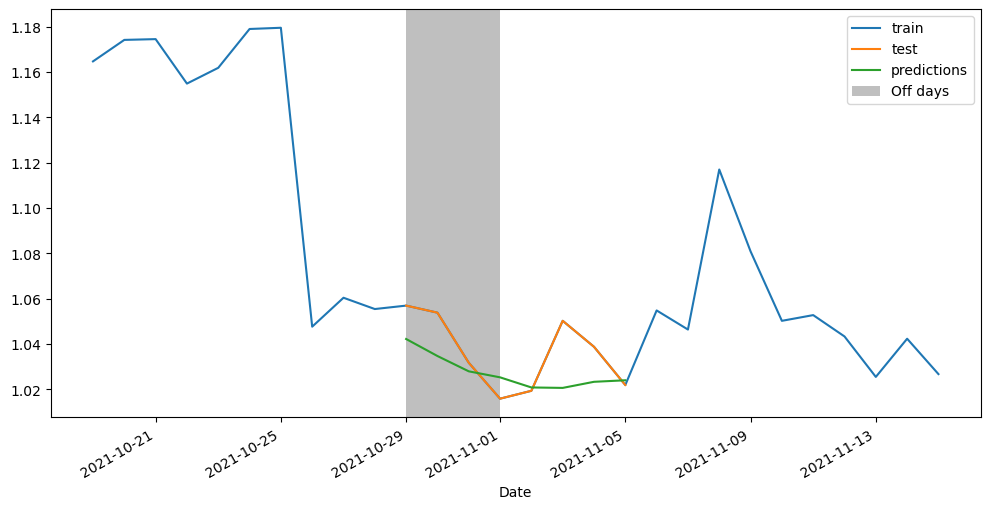

In [14]:
_, recursiveWindowForecast(de_off_dfs[30],'2021-10-29','2021-11-05', settings, params=params, refDf=de_ref_df, visualWindow=10)

